# Solving Maximum Independent Set Problem w/ Graph Convolutional Neural Network

For this project, I will be using a Graph Convolutional Neural Network (GCN) to generate approximate solutions to the maximum independent set problem given a graph G. For the implementation, I will be using the [**PyTorch**](https://github.com/pytorch/pytorch) library as well as the [**NetworkX**](https://github.com/networkx/networkx) library for graph representation.

## Imports
The first step is to import the required modules needed for this implementation. If attempting to run this code on your own machine and run into "module not found" errors, you may need to run a `pip install` command for the specified libraries.

- `torch`provides framework for manipulating tensors and implementing machine learning algorithms
- `torch.nn.functional` provides additional functions for implementing neural network functions
- `torch.optim` provides various optimization algorithms
- `networkx`provides framework for generating and manipulating graph data
- `torch_geometric.nn.GCNConv` graph convolutional network convolution operator
- `networkx.algorithms.approximation`provides complete approximation algorithms

- `math` is used in generating the underlying graphs
- `matplotlib.pyplot` allows us to plot the graphs generated by NetworkX
- `numpy` is used to track the running time of algorithms
- `time` is used to track the running time of algorithms


In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
from torch_geometric.nn import GCNConv
from networkx.algorithms import approximation as approx

import math
import matplotlib.pyplot as plt
import numpy as np
from time import time

## Creating Underlying Graph
I will now create the underlying graph to be used in the algorithm. To create the graph, I will be using the `nx.random_tree()` function which takes the following parameters:
- `n` [int] The number of nodes in the tree
- `seed` [integer, random_state, or None (default)] Indicator of random number generation state

I use a tree as a base for the graph to ensure that the graph is connected. If any nodes are not connected, then the fitness function will always be biased towards the unconnected nodes. After creating the base for the graph, I create a second graph using the `nx.gnm_random_graph()` function which takes in the following parameters:
- `n` [int] The number of nodes in the graph
- `m` [int] The number of edges
- `seed` [integer, random_state, or None (default)] Indicator of random number generation state
- `directed` [bool, optional (default=False)] If True return a directed graph

The edges from this graph are then added to the original tree to produce a deterministically random connected graph.

### Helper Function
The function `get_node_indexs` takes in a graph, **G** and an integer list representation of the provided maximum independent set **MIS** where each element in **MIS** represents the index of a node from **G** included in the set.

In [7]:
def generate_graph(n):
    #Genereate tree as base for final graph
    G_temp = nx.random_tree(n, seed=42)
    
    #Number of edges in addition graph
    k = math.sqrt(n)/2
    
    #Fill in tree with new edges
    G_temp.add_edges_from(nx.gnm_random_graph(n, n-1+k, seed=42).edges())

    G = nx.Graph()
    G.add_nodes_from(sorted(G_temp.nodes()))
    G.add_edges_from(G_temp.edges)

    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=[[.7, .7, .7]])
    plt.show()
    
    return G

# Function that converts indexes of MIS to binary representation
def get_node_indexs(G, MIS):
    #Return binary representation of MIS (same as individual type)
    result = [0] * G.order()
    for i in MIS:
        result[i] = 1
        
    return result

# Function that converts binary representation to NetworkX usable indexes
def getNodeIndexs(individual):
    nodes = []
    i = 0
    for bit in individual:        
        if bit==1:
            nodes.append(i)
        i += 1
        
    return nodes

#Create function to check if an individual represents an independent set
def isIndSet(G, individual):
    #Get indexs of 1's from individual
    nodes = getNodeIndexs(individual)
    
    #Check if node set is independent
    for u in nodes:
        for v in nodes:
            if u != v and G.has_edge(u,v):
                return False, nodes
    return True, nodes  

## Network Architecture
The next step is to define the network architecture. The class `GCN` inherits from the `torch.nn.Module` class and provides the foundation for the **graph convolutional network**. This GCN has two layers where the input to the network is a graph represented by `edge_index` and its node features `x`.

The output is a tensor of node-level predictions that have been passed through a sigmoid activation function.

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.sigmoid(x)
        return x

### Hyper Parameters
The following section holds some of the hyper parameters required for running the algorithm.
- `num_epochs`: The number of epochs the training loop will run for
- `learning_rate`: The step size at each iteration while updating model
- `dropout`: probability of dropout used in model creation

In [4]:
# num_epochs = 10000
num_epochs = 1000
learning_rate = 0.01
dropout = 0.0

## Wrapper for Running GCN
The below section runs the training loop for the GCN for each value of `n` in the specified range where n is used to generate a random graph of size n.

Each iteration of the loop does the following task:
1. Generate a deterministic random graph of size **n** by calling `generate_graph(n)`
2. Finds the standard target maximum independent set of G by calling `approx.maximum_independent_set(G)
3. Creates a new model based on the input parameters `input_dim`, `hidden_dim`, and `output_dim` by calling `GCN()`
4. Runs the training loop for `num_epochs` iterations
5. Display the results produced by GCN and time elapsed
6. Compares GCN results with target

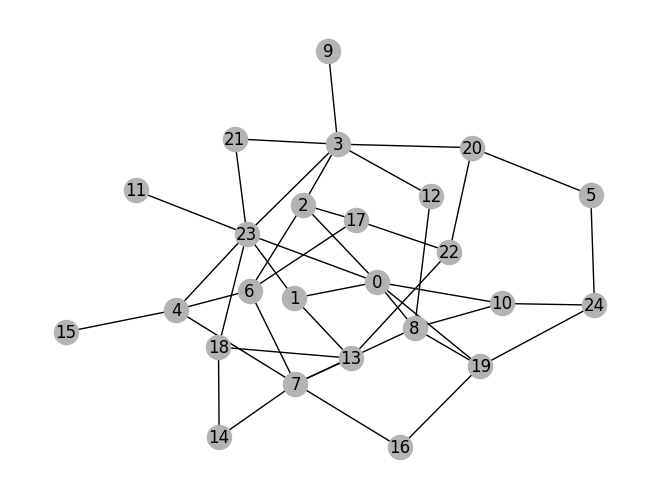

Epoch: 0, Loss: 0.6688275337219238
Epoch: 500, Loss: 0.009564577601850033


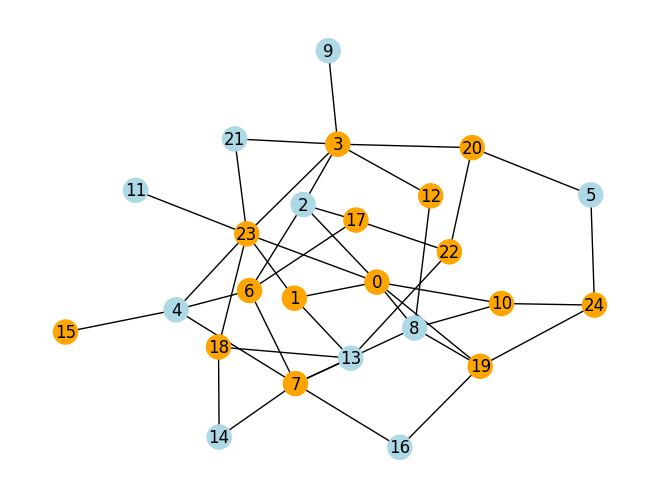

GNN training (n=25) took 0.933 seconds
Predicted Maximum Independent Set: [2, 4, 5, 8, 9, 11, 13, 14, 16, 21]
(True, [])
NX Provided approach (n=25) took 0.007 seconds
Maximum Independent Set:           {2, 4, 5, 8, 9, 11, 13, 14, 16, 21}
---------------------------------------------------------------------------------------------------------------


In [8]:
for n in range(25, 26):
    num_nodes = n
    
    #Generate Graph of size n 
    G = generate_graph(n)
    
    #Find and measure optimal MIS
    t_mis_start = time()
    mis_target = approx.maximum_independent_set(G)
    t_mis = time() - t_mis_start
    
    target = torch.FloatTensor(get_node_indexs(G, mis_target)).unsqueeze(1)
    
    #Model Input Parameters
    x = torch.eye(n)
    edge_index = torch.LongTensor(np.array(list(G.edges())).T)
    
    #Instantiate Model and Optimizer
    model = GCN(input_dim=n, hidden_dim=n//2, output_dim=1, dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    t_gnn_start = time()
    
    model.train()
    for epoch in range(num_epochs):
        
        out = model(x, edge_index)

        loss = F.binary_cross_entropy(out, target)
        
        if epoch % 500 == 0:
            print(f'Epoch: {epoch}, Loss: {loss}')   
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    t_gnn = time() - t_gnn_start
    
    
    # Extract the maximum independent set from the output of the GCN
    max_ind_set = torch.nonzero(out.squeeze() > 0.5).squeeze().tolist()
    mis_bin = get_node_indexs(G, torch.nonzero(out.squeeze() > 0.5).squeeze().tolist())
    
    # Display G with predicted MISP highlighted
    pos = nx.kamada_kawai_layout(G)
    color_map = ['orange' if (mis_bin[node]==0) else 'lightblue' for node in range(len(G.nodes))]
    nx.draw(G, pos, with_labels=True, node_color=color_map)
    plt.show()
    
    # Display results
    print(f'GNN training (n={len(G.nodes())}) took {round(t_gnn, 3)} seconds')
    print('Predicted Maximum Independent Set:', max_ind_set)
    print(f'NX Provided approach (n={len(G.nodes())}) took {round(t_mis, 3)} seconds')
    print('Maximum Independent Set:          ', mis_target)
    print('---------------------------------------------------------------------------------------------------------------')
    